### <h3 style="color: blue;">Step-by-Step Workflow:</h3>
1. **Load and explore the dataset**: Check the structure and contents of `train.csv` and `test.csv`.
2. **Preprocess the data**:
   - Handle missing data, scale features, create new features if needed.
3. **Split the dataset**:
   - Divide the dataset into training and validation sets.
4. **Train your model**:
   - Choose a model (start simple, like Logistic Regression, and experiment with more complex ones).
5. **Validate the model**:
   - Evaluate the model's performance and tune hyperparameters if needed.
6. **Predict on the test set**:
   - Use the trained model to make predictions on `test.csv`.
7. **Submit to Kaggle**:
   - Prepare the submission file and upload it to the competition page.!

### Step-by-Step Guide:

#### 1. **Understanding the Problem**
The task is to predict the **direction** of price movement of a cryptocurrency for the next minute using minute-by-minute historical data. Specifically, the goal is to predict whether the price will go **up (1)** or **stay the same / go down (0)** in the next minute based on the data provided for each minute.

This is a **classification problem** because I am predicting one of two categories: **0** or **1**.

In [1]:
import pandas as pd
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sample_submission = pd.read_csv('C:/Users/caiof/_repos/Directional-Forecasting-in-Cryptocurrencies/datasets/sample_submission.csv')
test_tb = pd.read_csv('C:/Users/caiof/_repos/Directional-Forecasting-in-Cryptocurrencies/datasets/test.csv')
train_df = pd.read_csv('C:/Users/caiof/_repos/Directional-Forecasting-in-Cryptocurrencies/datasets/train.csv')

#### 2. **Exploring the Dataset**
I am provided with historical data (OHLCV format), which includes:
- **Timestamp**: Time when the data was recorded.
- **Open, High, Low, Close Prices (OHLC)**: These represent the price behavior during that minute.
- **Volume**: Number of crypto units traded.
- **Other Features**: Including total trade value, number of trades, and specific taker buy volumes.

The most important column for prediction is the **target**, which indicates the price movement direction in the next minute.

Before starting with modeling, it’s important to **explore** the dataset:
- **Look at the summary** of the data: Check if there are missing values, outliers, or any unusual patterns.
- **Visualize the data**: Create plots (e.g., line plots for price changes) to understand how the features vary over time.


### sample_submission

In [3]:
sample_submission.dtypes

row_id    int64
target    int64
dtype: object

In [17]:
sample_submission.head()

,row_id,target
0,0,0
1,1,0
2,2,1
3,3,1
4,4,1


In [4]:
sample_submission.describe()

,row_id,target
count,50.00000,50.000000
mean,24.50000,0.400000
std,14.57738,0.494872
min,0.00000,0.000000
25%,12.25000,0.000000
50%,24.50000,0.000000
75%,36.75000,1.000000
max,49.00000,1.000000


### Observations:
Row ID: It’s just an index ranging from 0 to 49. It's not a feature but will be used for submission formatting.

Target: Represents the direction of the price movement. The mean is 0.4, indicating that in 40% of the cases, the price increases (target = 1). The rest are either unchanged or down (target = 0).

50th percentile (median) is 0.0, suggesting that in half the sample, the price did not go up.

The 75th percentile is 1.0, indicating that price increases in the top 25% of cases.

This sample submission is small, but it gives you a general idea of how the output should look. You’ll later match the row_id to your predictions for submission.

### test_tb

In [5]:
test_tb.dtypes

row_id                      int64
timestamp                   int64
open                      float64
high                      float64
low                       float64
close                     float64
volume                    float64
quote_asset_volume        float64
number_of_trades          float64
taker_buy_base_volume     float64
taker_buy_quote_volume    float64
dtype: object

In [6]:
# Convert the timestamp column
test_tb['timestamp'] = pd.to_datetime(test_tb['timestamp'], unit='s')

In [18]:
test_tb.head()

,row_id,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_volume,taker_buy_quote_volume
0,0,2022-05-17 19:58:00,0.4306,0.4308,0.4301,0.4301,101150.0,43542.2629,105.0,46109.0,19851.7237
1,1,2022-05-17 19:59:00,0.4301,0.4303,0.4293,0.4302,275647.0,118478.9689,228.0,91260.0,39217.6312
2,2,2022-05-17 20:00:00,0.4302,0.4302,0.4292,0.4299,134959.0,57979.2418,156.0,56685.0,24357.5448
3,3,2022-05-17 20:01:00,0.4299,0.4303,0.4299,0.4301,316209.0,135979.4040,121.0,161740.0,69552.2691
4,4,2022-05-17 20:02:00,0.4302,0.4307,0.4302,0.4303,107440.0,46243.7993,113.0,31096.0,13384.3384


In [7]:
test_tb.describe()

,row_id,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_volume,taker_buy_quote_volume
count,909617.000000,909617,909617.000000,909617.000000,909617.000000,909617.000000,9.096170e+05,9.096170e+05,909617.000000,9.096170e+05,9.096170e+05
mean,454808.000000,2023-03-29 16:06:00.000000512,0.468089,0.468342,0.467828,0.468102,2.484656e+05,1.187006e+05,149.763820,1.239818e+05,5.920098e+04
min,0.000000,2022-05-17 19:58:00,0.288400,0.290600,0.287200,0.288400,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
25%,227404.000000,2022-10-22 18:02:00,0.379700,0.379900,0.379500,0.379700,7.538700e+04,3.355523e+04,53.000000,3.209500e+04,1.433058e+04
50%,454808.000000,2023-03-29 16:06:00,0.466500,0.466800,0.466300,0.466600,1.472370e+05,6.706755e+04,88.000000,6.982900e+04,3.166280e+04
75%,682212.000000,2023-09-03 14:10:00,0.521300,0.521500,0.521100,0.521300,2.748180e+05,1.285332e+05,151.000000,1.398770e+05,6.513958e+04
max,909616.000000,2024-02-08 12:14:00,0.909000,0.938000,0.899000,0.909100,4.083906e+07,2.218319e+07,48569.000000,2.227382e+07,1.153613e+07
std,262583.954241,NaN,0.104381,0.104434,0.104319,0.104384,4.606647e+05,2.494472e+05,364.157423,2.343786e+05,1.268206e+05


### Observations:
* Timestamp: Represents the time in Unix format (seconds since 1970), covering a period from approximately 1.65 billion to 1.71 billion seconds, which translates to a range from the year 2022 to 2023.
* OHLC (Open, High, Low, Close):
    * The values are mostly within the 0.288 to 0.909 range, suggesting that the price of the cryptocurrency is measured in fractions of USDT (e.g., it might be a low-value cryptocurrency).
    * The mean and median (50%) of the open, high, low, and close prices are all very close, indicating small price changes within each minute.
* Volume & Quote Asset Volume: The mean volume of trades is 248,465 units, but the standard deviation is quite high, indicating significant variability in the number of units traded. The quote asset volume is the value of these units in USDT.
* Number of Trades: Ranges from 0 to 48,569 trades per minute. The median number is 88, suggesting that in half of the minutes, fewer than 88 trades occurred.
* Taker Buy Volumes: Measures the amount bought by takers (market participants). The values range from 0 to 22 million USDT.

The test set provides you with similar data to train on, but without the target column. This will be used to make predictions and submit your results.

### train_df

In [8]:
train_df.dtypes

timestamp                   int64
open                      float64
high                      float64
low                       float64
close                     float64
volume                    float64
quote_asset_volume        float64
number_of_trades          float64
taker_buy_base_volume     float64
taker_buy_quote_volume    float64
target                    float64
dtype: object

In [9]:
# Convert the timestamp column
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'], unit='s')

In [19]:
train_df.head()

,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_volume,taker_buy_quote_volume,target,price_diff,high_low_diff
0,2018-05-04 22:01:00,0.90120,0.90130,0.90120,0.90130,134.98,121.646459,4.0,125.08,112.723589,1.0,0.00010,0.00010
1,2018-05-04 22:02:00,0.90185,0.90195,0.90185,0.90195,1070.54,965.505313,12.0,879.94,793.612703,0.0,0.00010,0.00010
2,2018-05-04 22:03:00,0.90140,0.90140,0.90139,0.90139,2293.06,2066.963991,5.0,0.00,0.000000,0.0,-0.00001,0.00001
3,2018-05-04 22:04:00,0.90139,0.90140,0.90138,0.90139,6850.59,6175.000909,19.0,1786.30,1610.149485,0.0,0.00000,0.00002
4,2018-05-04 22:05:00,0.90139,0.90139,0.90130,0.90130,832.30,750.222624,3.0,784.82,707.428900,0.0,-0.00009,0.00009


In [10]:
train_df.describe()

,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_volume,taker_buy_quote_volume,target
count,2122438,2.122438e+06,2.122438e+06,2.122438e+06,2.122438e+06,2.122438e+06,2.122438e+06,2.122438e+06,2.122438e+06,2.122438e+06,2.122438e+06
mean,2020-05-10 20:59:29.999994880,4.971020e-01,4.976028e-01,4.965936e-01,4.971011e-01,2.484890e+05,1.650106e+05,2.121758e+02,1.237279e+05,8.230815e+04,4.757849e-01
min,2018-05-04 22:01:00,1.057300e-01,1.068400e-01,1.012900e-01,1.058900e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2019-05-08 09:30:15,2.676100e-01,2.678200e-01,2.673900e-01,2.676000e-01,2.498430e+04,7.835293e+03,2.700000e+01,1.083690e+04,3.409231e+03,0.000000e+00
50%,2020-05-10 20:59:30,3.629800e-01,3.633400e-01,3.626000e-01,3.629700e-01,7.833306e+04,2.853193e+04,6.800000e+01,3.622145e+04,1.362004e+04,0.000000e+00
75%,2021-05-14 08:28:45,6.572000e-01,6.579550e-01,6.563000e-01,6.572000e-01,2.334948e+05,1.315786e+05,1.970000e+02,1.145778e+05,6.322541e+04,1.000000e+00
max,2022-05-17 19:58:00,1.964710e+00,1.966890e+00,1.958350e+00,1.964710e+00,6.366178e+07,3.556471e+07,4.053500e+04,3.087021e+07,1.602615e+07,1.000000e+00
std,NaN,3.147919e-01,3.152553e-01,3.143317e-01,3.147945e-01,6.416383e+05,4.887013e+05,5.372650e+02,3.249252e+05,2.488676e+05,4.994134e-01


### Observations:
* Target: The mean value of the target is 0.476, which means about 47.6% of the time the price increases. The other 52.4% of the time, the price either stays the same or decreases.
    * This shows a relatively balanced dataset, but it’s slightly biased towards price staying the same or going down (target = 0).
* OHLC Data:
    * The values range from 0.106 to 1.965, which again suggests that the cryptocurrency is priced in fractions of USDT.
* Volume: There’s a large variability in trading volumes, with a median volume of about 78,333 units, but the max is 63 million units, indicating outliers.
* Trades: The number of trades also varies significantly, with a median of 68 trades per minute and a maximum of over 40,000 trades in a minute.

This data will be used for training, with the target variable indicating whether the price goes up (1) or stays the same/goes down (0). You'll need to preprocess this data before fitting models.

### Key Points for Data Exploration:
* Timestamp: Will likely need to be converted into readable time formats, and features like hour, day, or minute might be extracted.
* Target Variable: Slightly imbalanced, but not severely.
* OHLC Features: These provide key information about price changes over time and will likely be important for predicting the target.
* Volume and Trade Metrics: These might also serve as predictors of price movements, especially as they capture the intensity of market activity.

### 2.1 Visualize the Distribution of Key Features
Plot histograms or KDE plots to visualize the distribution of numerical features like open, high, low, close, volume, etc. This helps to understand the data’s spread, potential outliers, and skewness.

I should specifically check:

Open, High, Low, Close prices: These might follow a specific distribution.
Volume and Number of Trades: You want to see how frequently different trade volumes occur and if there are spikes or outliers.

<Figure size 1200x600 with 0 Axes>

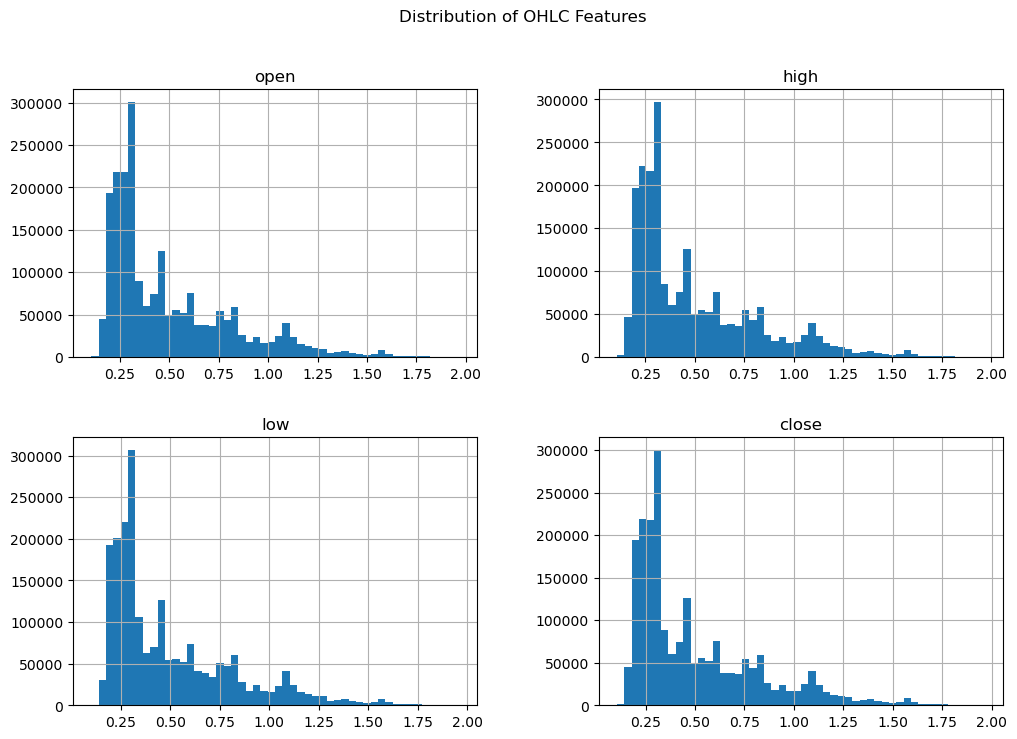

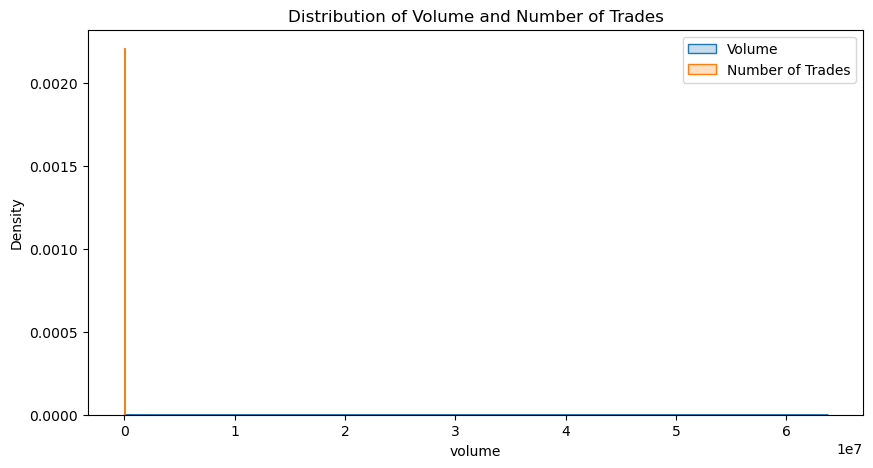

In [11]:
# Histogram for price features
plt.figure(figsize=(12, 6))
train_df[['open', 'high', 'low', 'close']].hist(bins=50, layout=(2, 2), figsize=(12, 8))
plt.suptitle("Distribution of OHLC Features")
plt.show()

# KDE for volume and number of trades
plt.figure(figsize=(10, 5))
sns.kdeplot(train_df['volume'], label='Volume', fill=True) #shade=True)
sns.kdeplot(train_df['number_of_trades'], label='Number of Trades', fill=True) #shade=True)
plt.title('Distribution of Volume and Number of Trades')
plt.legend()
plt.show()

Let's analyze the results of the visualizations:

### 1. **Histogram for OHLC Features (Open, High, Low, Close)**:
   The four histograms (for `open`, `high`, `low`, and `close` prices) share similar patterns:
   - **Skewed Distribution**: All the features appear to be skewed to the right (positively skewed). This means that the majority of the data points are concentrated around lower price values, and there are fewer high-price observations. 
   - **Price Range**: The majority of the price values fall between approximately **0.25 and 0.75 USDT**. After 1 USDT, the number of observations drops significantly.
   - **Potential Outliers**: There may be a few high-price outliers, but these are rare, indicated by the long tail on the right side of the distributions.
   
   **Insight**: This kind of distribution is common in financial data, where the price movements are usually concentrated around a typical value, with occasional large spikes. The long tails and skewness suggest that the dataset might have some outliers or large variations in the price.

### 2. **KDE Plot for Volume and Number of Trades**:
   In this plot:
   - **Volume Distribution**: The distribution for `volume` is highly skewed and seems to have a very sharp peak near 0. This implies that there are many periods where the trading volume is very low or almost zero, which could be because the cryptocurrency market is almost inactive during those times.
   - **Number of Trades**: The distribution of `number_of_trades` is also extremely skewed, with the vast majority of trades occurring at a very low number. There are almost no periods with a high number of trades.

   **Insight**: The low trading volume and number of trades suggest that there are many time periods in the dataset where the market was quiet or inactive. This could be important for modeling, as the periods with little to no trading activity may behave differently compared to high-activity periods. You may also want to explore these low-volume periods separately or handle them during preprocessing to avoid their influence on predictions.

### Possible Corrections

1. **Log Transformation**: Since the `open`, `high`, `low`, and `close` features are heavily skewed, it might be useful to apply a **log transformation** to these features to normalize their distributions. This can improve model performance when using algorithms that are sensitive to feature distributions.
   
2. **Handling Outliers**: The long right tails suggest the presence of outliers, particularly in the price data. I might want to explore techniques such as **capping extreme values** or using **robust scaling** to reduce the impact of these outliers on the model.

3. **Special Attention to Zero or Low Volume/Trades**: The extremely low trading volume and number of trades may require special handling. It might be wise to either remove periods with no activity or create features that flag periods of inactivity, as they may behave differently in terms of price movement.

### 1.2 Check for Missing Data
Investigate whether there are missing or null values in the dataset. This helps ensure data quality and identify if you need to fill or drop missing data later.

In [12]:
# Check for missing values
missing_values = train_df.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


### 1.3 Plot Time Series of Price Data
Since the data is time-dependent (minute-by-minute), visualize how the close price evolves over time. This can give you an idea of the trends or volatility in the cryptocurrency.

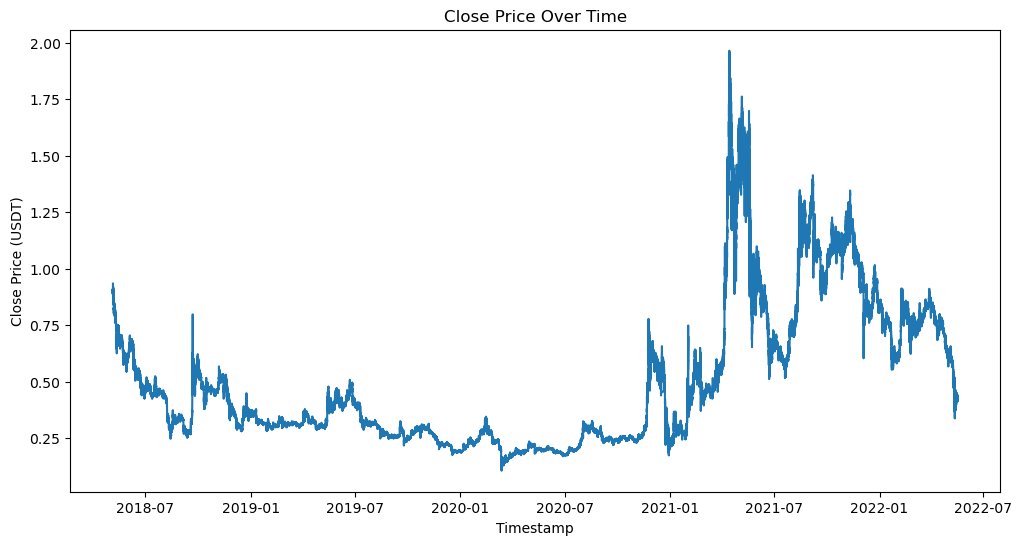

In [13]:
# Plot time series of the close price
plt.figure(figsize=(12, 6))
plt.plot(train_df['timestamp'], train_df['close'])
plt.title('Close Price Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Close Price (USDT)')
plt.show()


### 1.4 Correlations Between Features
Use a correlation matrix to understand the relationships between numerical features. This is useful for identifying strong correlations that might help you in feature selection or engineering.

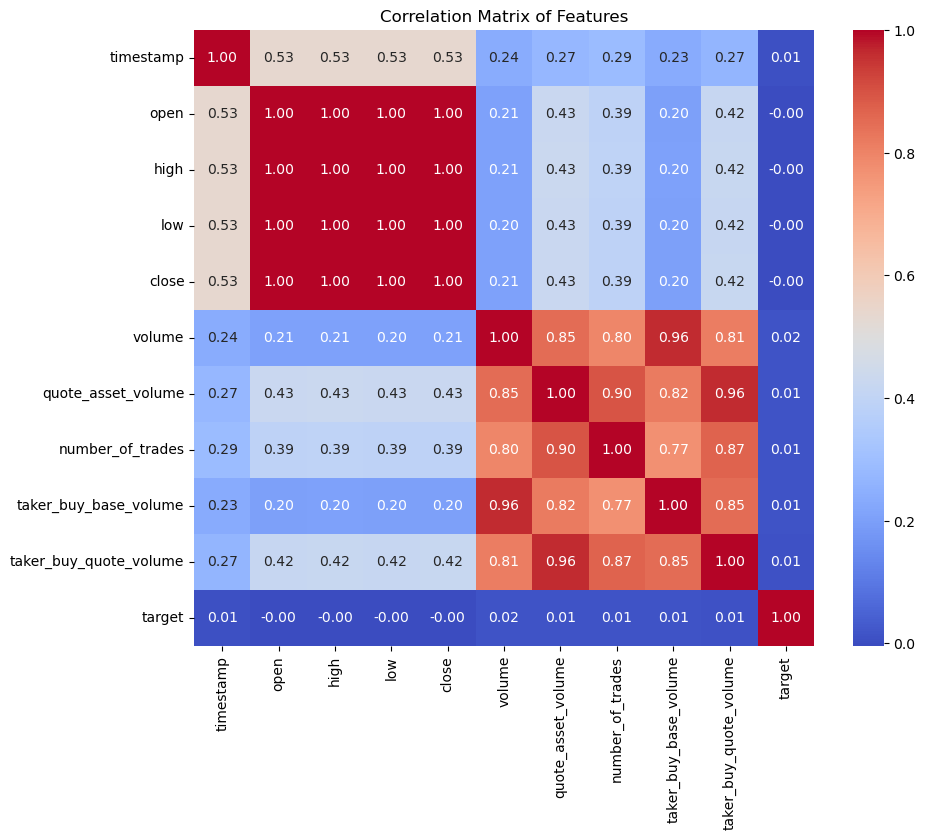

In [14]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(train_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Features')
plt.show()


### 1.5 Explore Price Differences (Volatility)
Create new features for price differences, such as high - low, close - open, or percentage change. This can give insights into price volatility, which may be a strong predictor of future price movements.

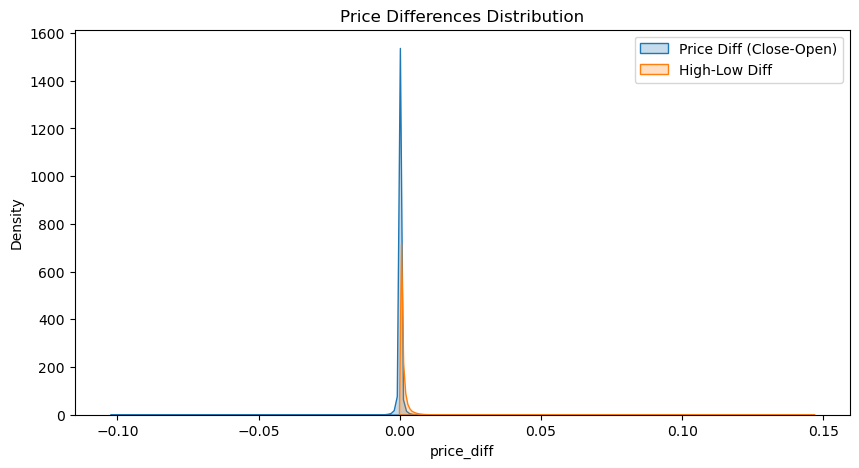

In [15]:
# Add price difference columns
train_df['price_diff'] = train_df['close'] - train_df['open']
train_df['high_low_diff'] = train_df['high'] - train_df['low']

# Visualize the distribution of these new features
plt.figure(figsize=(10, 5))
sns.kdeplot(train_df['price_diff'], label='Price Diff (Close-Open)', fill=True) #shade=True)
sns.kdeplot(train_df['high_low_diff'], label='High-Low Diff', fill=True) #shade=True)
plt.title('Price Differences Distribution')
plt.legend()
plt.show()


### 1.6 Study Volume and Trades Behavior
Plot the volume and number_of_trades over time. This can help identify periods of high trading activity, which might correlate with price volatility.

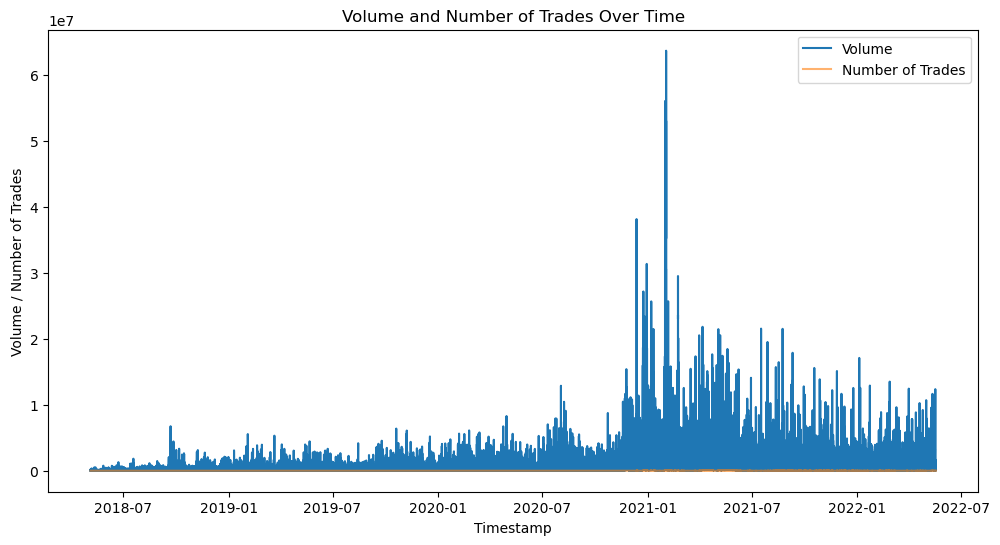

In [16]:
# Plot volume and number of trades over time
plt.figure(figsize=(12, 6))
plt.plot(train_df['timestamp'], train_df['volume'], label='Volume')
plt.plot(train_df['timestamp'], train_df['number_of_trades'], label='Number of Trades', alpha=0.6)
plt.title('Volume and Number of Trades Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Volume / Number of Trades')
plt.legend()
plt.show()


### Summary of Tasks to Perform:
* Visualize the distribution of numerical features (prices, volume, trades).
* Check for missing data.
* Analyze the distribution of the target variable (target).
* Plot time series for prices (especially close).
* Examine correlations between features.
* Explore volatility by calculating price differences.
* Investigate how volume and number_of_trades vary over time.

These explorations will give you a better sense of the data's structure, relationships, and any underlying patterns. This knowledge is essential before moving on to Step 3: Preprocessing the Data.


#### 3. **Preprocessing the Data**
Data preprocessing is a critical step to prepare the dataset for modeling:
- **Handling Missing Values**: Check if there are missing values in any columns and decide how to handle them (e.g., remove rows or fill them with the mean).
- **Feature Scaling**: Since machine learning models can be sensitive to scale, especially algorithms like logistic regression or neural networks, I may need to **normalize** or **standardize** the numerical features (e.g., using MinMaxScaler or StandardScaler).
- **Create New Features**:
    - Calculate **price returns** (the percentage change between the opening and closing price).
    - Compute **technical indicators** like moving averages, exponential moving averages, or Relative Strength Index (RSI), which are often used in time-series financial data.
    - Use the **timestamp** to extract additional time-based features like **hour of the day** or **day of the week**.



#### 4. **Splitting the Dataset**
- **Training and Validation Set**: Usually, I'll need to split my dataset into a **training set** (for training your model) and a **validation set** (to check the model's performance before submitting predictions).
- I can use **time-based cross-validation** since this is time-series data. A typical strategy is to divide the data into chunks (train on past data, test on future data).



#### 5. **Selecting the Model**
This is a binary classification problem, so I can use several different machine learning models:
- **Logistic Regression**: Simple and interpretable.
- **Random Forest** or **Gradient Boosting (XGBoost, LightGBM)**: Powerful tree-based models.
- **Neural Networks (LSTM, GRU)**: More complex models that can capture time dependencies in the data.

I'll need to experiment with different models and evaluate their performance using metrics like **accuracy** or **F1-score** (since there are only two possible outcomes).



#### 6. **Model Evaluation**
- Evaluate my model on the **validation set**.
- Since this is a classification problem, I want to monitor metrics like:
    - **Accuracy**: Percentage of correct predictions.
    - **Precision/Recall**: For understanding how well the model is performing in detecting upward price movements.
    - **F1-score**: A balance between precision and recall.
    - **Confusion Matrix**: To analyze false positives and false negatives.
  
I should also be cautious about overfitting. If my model performs well on the training set but poorly on the validation set, it may be overfitting to the training data.



#### 7. **Feature Importance**
Tree-based models like **Random Forest** or **XGBoost** allow me to see the importance of features in the prediction. This can help you understand which features are most useful for predicting price movement (e.g., volume, closing price, number of trades).



#### 8. **Prediction on Test Set and Submission**
Once my model is trained and validated, it’s time to:
- **Predict on the test set**.
- Create a **submission file** (following the format in `sample_submission.csv`), which contains the predictions for each minute in the test data.

For Kaggle, my submission file typically needs to have two columns: **id (or timestamp)** and the **predicted direction (0 or 1)**.
